In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re

from langdetect import detect
from scipy.stats import f_oneway
from collections import Counter

nltk.download("stopwords", quiet=True)b n

from nltk.stem.snowball import SpanishStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.linear_model import LogisticRegression

from matplotlib.colors import LinearSegmentedColormap

In [51]:
colors = ['#98DFEA', '#07BEB8', '#084B83']

In [52]:
class WordTokenizerTransformer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        # No necesita entrenamiento pero permite compatibilidad scikit-learn
        self.stem = False
        self.wpt = nltk.WordPunctTokenizer()
        self.stop_words = set(nltk.corpus.stopwords.words("spanish"))
        self.spanish_stemmer = SpanishStemmer()
        return self

    def transform(self, X):

        tokenized_text = []
        
        for text in X:
            doc = re.sub(r"[^A-Za-zÁÉÍÓÚáéíóúÜüÑñ\s]", "", text, flags=re.U)  # Unicode aware
            doc = doc.lower()
            doc = doc.strip()
            tokens = self.wpt.tokenize(doc)
            # Filtrar palabras
            filtered_tokens = [
                self.spanish_stemmer.stem(token) if self.stem else token
                for token in tokens
                if token not in self.stop_words
            ]
            # Recrear documento de texto
            doc = " ".join(filtered_tokens)
            tokenized_text.append(doc)
        return tokenized_text


    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)



In [53]:
df_data = pd.read_excel(r"datos/Datos_proyecto.xlsx")

# Modelo Pasado

In [54]:
print("===Count==")
print(df_data.count())
# Valores nulos por columna
print("==Datos Nulos==")
print(df_data.isnull().sum())

print("==Eliminar filas sin texto o etiqueta==")
df = df_data.dropna(subset=["textos", "labels"])
print(df.count())

print("==verificar si hay textos con strings vacíos==")
num_empty = (df["textos"].str.strip() == "").sum()
print("Número de textos vacíos:", num_empty)

print("==Unicidad==")
duplicados = df.duplicated(subset=["textos"])
print(f"Duplicados encontrados: {duplicados.sum()}")

print("== Eliminar duplicados exactos (mismo texto y misma etiqueta ==")
df = df.drop_duplicates(subset=["textos", "labels"])
df.count()


===Count==
textos    2424
labels    2424
dtype: int64
==Datos Nulos==
textos    0
labels    0
dtype: int64
==Eliminar filas sin texto o etiqueta==
textos    2424
labels    2424
dtype: int64
==verificar si hay textos con strings vacíos==
Número de textos vacíos: 0
==Unicidad==
Duplicados encontrados: 0
== Eliminar duplicados exactos (mismo texto y misma etiqueta ==


textos    2424
labels    2424
dtype: int64

In [55]:
# 9. Distribución de etiquetas
print("Distribución de clases:")
dist_df = pd.DataFrame(
    {
        "cantidad": df["labels"].value_counts(),
        "porcentaje": round(df["labels"].value_counts() / len(df), 2),
    }
)
print(dist_df)

Distribución de clases:
        cantidad  porcentaje
labels                      
4           1025        0.42
3            894        0.37
1            505        0.21


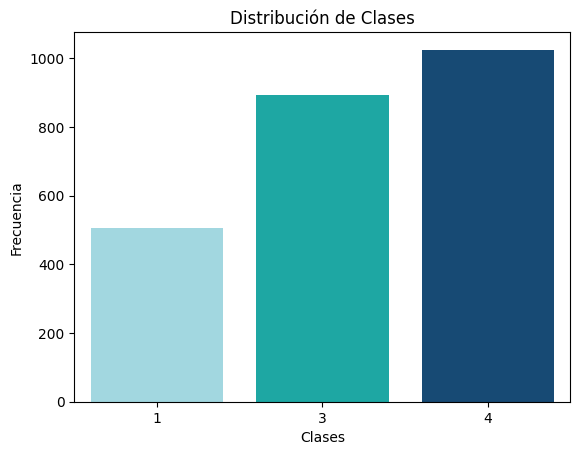

In [56]:
def distribucion_clases(df):
    value_counts = df["labels"].value_counts()
    x_values = value_counts.index
    y_values = value_counts.values

    sns.barplot(x=x_values, y=y_values, palette=colors, hue=x_values, legend=False)

    plt.title("Distribución de Clases")
    plt.xlabel("Clases")
    plt.ylabel("Frecuencia")
    plt.show()

distribucion_clases(df)


In [57]:
X = df["textos"]
y = df["labels"]
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_test_text.head

<bound method NDFrame.head of 1490    Por lo general, se entiende que los trastornos...
387     En la mayoría de los contratos, el objetivo es...
1419    Las tasas de consumo de alcohol y tabaquismo n...
410     Hubo una disminución constante en el porcentaj...
482     La oferta insuficiente de programas vocacional...
                              ...                        
220     Cuando todavía era posible suponer que lo que ...
1894    Las opiniones expresadas y los argumentos empl...
2377    Por lo tanto, la definición de indicadores nac...
1772    De las 203 organizaciones de atención primaria...
2145    Sin embargo, gracias a este proyecto, los serv...
Name: textos, Length: 364, dtype: object>

In [58]:
#Tokenizar columnas
tokenizer = WordTokenizerTransformer()
X_train_tokenized = tokenizer.fit_transform(X_train_text)
X_test_tokenized = tokenizer.transform(X_test_text)


#Entrenar
vectorizer_ngram = CountVectorizer(ngram_range=(1, 1))
X_train_vec = vectorizer_ngram.fit_transform(X_train_tokenized)
X_test_vec = vectorizer_ngram.transform(X_test_tokenized)
best_model_1 = LogisticRegression(max_iter=1000, random_state=42)
best_model_1.fit(X_train_vec, y_train)

# Predicción y evaluación
y_preds = best_model_1.predict(X_test_vec)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           1       0.97      0.93      0.95        82
           3       0.96      0.99      0.98       125
           4       0.99      0.99      0.99       157

    accuracy                           0.98       364
   macro avg       0.97      0.97      0.97       364
weighted avg       0.98      0.98      0.98       364



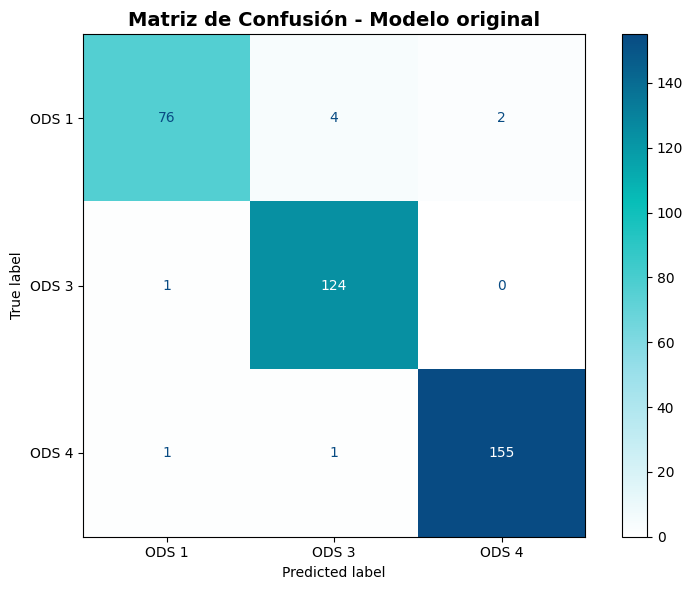

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

def matriz_confusion(y_true, y_pred, etiquetas=None, titulo="Matriz de Confusión"):
    """
    Dibuja una matriz de confusión con colores personalizados.
    """
    colors = ['#FFFFFF', '#98DFEA', '#07BEB8', '#084B83']
    custom_cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)

    # Validación de longitudes
    if len(y_true) != len(y_pred):
        raise ValueError(f"Las longitudes no coinciden: y_true={len(y_true)}, y_pred={len(y_pred)}")

    # Usar los parámetros, no variables globales
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=etiquetas)
    disp.plot(cmap=custom_cmap, values_format="d", ax=ax)
    plt.title(titulo, fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

matriz_confusion(
    y_true=y_test,
    y_pred=y_preds,
    etiquetas=["ODS 1", "ODS 3", "ODS 4"],
    titulo="Matriz de Confusión - Modelo original"
)

In [60]:
df_data_2 = pd.read_excel(r"datos/Datos_etapa 2.xlsx")

In [61]:
print("===Count==")
print(df_data_2.count())
# Valores nulos por columna
print("==Datos Nulos==")
print(df_data_2.isnull().sum())

print("==Eliminar filas sin texto o etiqueta==")
df2 = df_data_2.dropna(subset=["textos", "labels"])
print(df2.count())

print("==verificar si hay textos con strings vacíos==")
num_empty = (df2["textos"].str.strip() == "").sum()
print("Número de textos vacíos:", num_empty)

print("==Unicidad==")
duplicados = df2.duplicated(subset=["textos"])
print(f"Duplicados encontrados: {duplicados.sum()}")

print("== Eliminar duplicados exactos (mismo texto y misma etiqueta ==")
df2 = df2.drop_duplicates(subset=["textos", "labels"])
df2.count()


===Count==
textos    99
labels    99
dtype: int64
==Datos Nulos==
textos    0
labels    0
dtype: int64
==Eliminar filas sin texto o etiqueta==
textos    99
labels    99
dtype: int64
==verificar si hay textos con strings vacíos==
Número de textos vacíos: 0
==Unicidad==
Duplicados encontrados: 0
== Eliminar duplicados exactos (mismo texto y misma etiqueta ==


textos    99
labels    99
dtype: int64

Distribución de clases:
        cantidad  porcentaje
labels                      
4             43        0.43
3             35        0.35
1             21        0.21


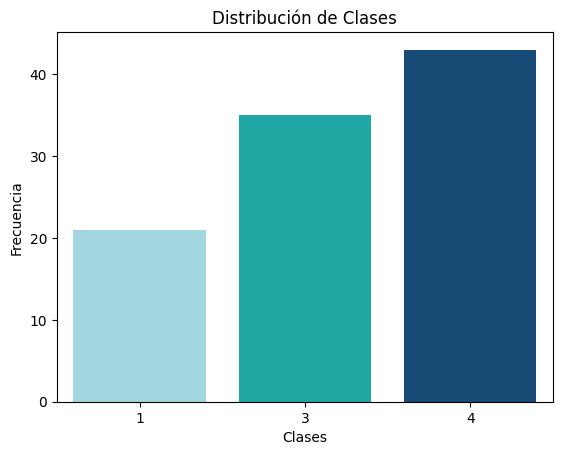

In [62]:
print("Distribución de clases:")
dist_df2 = pd.DataFrame(
    {
        "cantidad": df2["labels"].value_counts(),
        "porcentaje": round(df2["labels"].value_counts() / len(df2), 2),
    }
)
print(dist_df2)
distribucion_clases(df2)

In [63]:
X_new = df2["textos"]
y_new = df2["labels"]

              precision    recall  f1-score   support

           1       1.00      0.67      0.80        21
           3       0.83      1.00      0.91        35
           4       0.93      0.93      0.93        43

    accuracy                           0.90        99
   macro avg       0.92      0.87      0.88        99
weighted avg       0.91      0.90      0.90        99



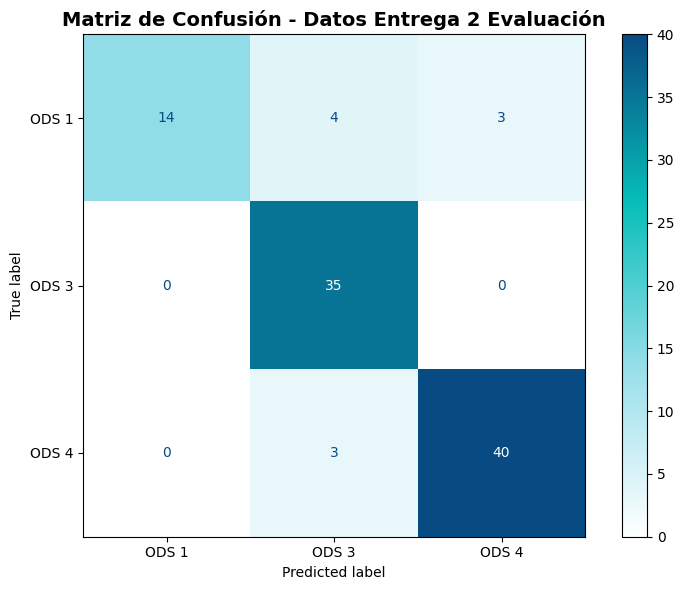

In [64]:
X_new_tokenized = tokenizer.transform(X_new)

# Reusar el vectorizer del train
X_new_vec = vectorizer_ngram.transform(X_new_tokenized)
y_new_pred = best_model_1.predict(X_new_vec)
print(classification_report(y_new, y_new_pred))
matriz_confusion(
    y_true=y_new,
    y_pred=y_new_pred,
    etiquetas=["ODS 1", "ODS 3", "ODS 4"],
    titulo="Matriz de Confusión - Datos Entrega 2 Evaluación"
)

In [65]:
df_concat = pd.concat([df, df2])

Distribución de clases:
        cantidad  porcentaje
labels                      
4           1068        0.42
3            929        0.37
1            526        0.21


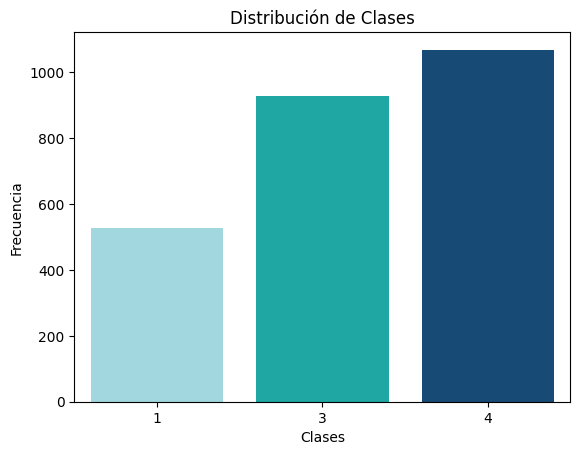

In [66]:
print("Distribución de clases:")
dist_df = pd.DataFrame(
    {
        "cantidad": df_concat["labels"].value_counts(),
        "porcentaje": round(df_concat["labels"].value_counts() / len(df_concat), 2),
    }
)
print(dist_df)
distribucion_clases(df_concat)

In [67]:
X = df_concat["textos"]
y = df_concat["labels"]
X_train_real, X_temp, y_train_real, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=40
)

X_val_real, X_test_real, y_val_real, y_test_real = train_test_split(
    X_temp, y_temp,
    test_size=(1/3), 
    stratify=y_temp,
    random_state=40
)

In [68]:
# Crear DataFrames para cada conjunto
df_train_real = pd.DataFrame({"textos": X_train_real, "labels": y_train_real})
df_val_real = pd.DataFrame({"textos": X_val_real, "labels": y_val_real})
df_test_real = pd.DataFrame({"textos": X_test_real, "labels": y_test_real})


In [69]:
train_texts = set(df_train_real["textos"])
val_texts = set(df_val_real["textos"])
test_texts = set(df_test_real["textos"])
print("Train/Val overlap:", len(train_texts & val_texts))
print("Train/Test overlap:", len(train_texts & test_texts))
print("Val/Test overlap:", len(val_texts & test_texts))

Train/Val overlap: 0
Train/Test overlap: 0
Val/Test overlap: 0


In [70]:
print("Tamaños -> train:", len(df_train_real), "val:", len(df_val_real), "test:", len(df_test_real))
print("Distribución original en train:\n", df_train_real["labels"].value_counts())

Tamaños -> train: 1766 val: 504 test: 253
Distribución original en train:
 labels
4    755
3    637
1    374
Name: count, dtype: int64


In [71]:
tokenizer_concat = WordTokenizerTransformer()
X_train_tokenized_concat = tokenizer_concat.fit_transform(X_train_real)
X_val_tokenized_concat = tokenizer_concat.transform(X_val_real)

Modelo sin aumento:
              precision    recall  f1-score   support

           1       0.95      0.94      0.95       101
           3       0.96      0.97      0.97       195
           4       0.99      0.99      0.99       208

    accuracy                           0.97       504
   macro avg       0.97      0.97      0.97       504
weighted avg       0.97      0.97      0.97       504



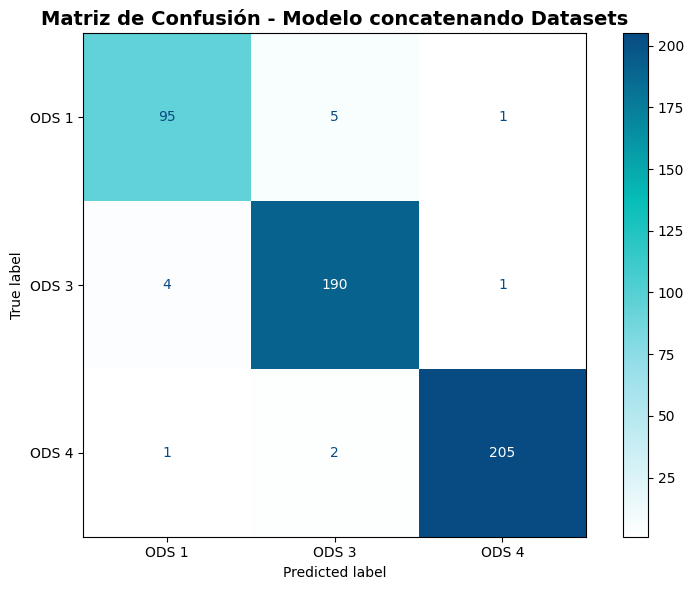

In [72]:
vectorizer_real = CountVectorizer(ngram_range=(1,1))
X_train_vec_real = vectorizer_real.fit_transform(X_train_tokenized_concat)
X_val_vec_real = vectorizer_real.transform(X_val_tokenized_concat)

model_real = LogisticRegression(max_iter=1000, random_state=42)
model_real.fit(X_train_vec_real, y_train_real)

y_val_pred_real = model_real.predict(X_val_vec_real)
print("Modelo sin aumento:")
print(classification_report(y_val_real, y_val_pred_real))
matriz_confusion(
    y_true=y_val_real,
    y_pred=y_val_pred_real,
    etiquetas=["ODS 1", "ODS 3", "ODS 4"],
    titulo="Matriz de Confusión - Modelo concatenando Datasets"
)

In [73]:
df_train_real.to_excel(r"df_retrain/datos_train.xlsx", index=False)
df_val_real.to_excel(r"df_retrain/datos_val.xlsx", index=False)
df_test_real.to_excel(r"df_retrain/datos_test.xlsx", index=False)

In [74]:
df_train = pd.read_excel(r"df_retrain/datos_train.xlsx")
df_val = pd.read_excel(r"df_retrain/datos_val.xlsx")
df_test = pd.read_excel(r"df_retrain/datos_test.xlsx")

In [75]:
#La parte de creación de datos sinteticos correrla una única vez para generar el dataframe de pruebas. Luego guardar en xlsx para su recuperación
from pathlib import Path
import sys, site, platform, os, subprocess,time

# cargar dotenv (instala python-dotenv si hace falta)
try:
    from dotenv import load_dotenv
    load_dotenv()   # carga .env desde el working dir o sus padres
except Exception:
    pass

secret = os.getenv("OPENAI_API_KEY")
if not secret:
    raise RuntimeError(
        "OPENAI_API_KEY no encontrada. Verifica .env en la ruta y que tenga formato: OPENAI_API_KEY=sk-... (sin comillas)"
    )

# No imprimir la clave. Verificar solo que se cargó:
print("OPENAI_API_KEY cargada correctamente:", bool(secret))

OPENAI_API_KEY cargada correctamente: True


In [76]:
print("Python exe:", sys.executable)
print("Version:", sys.version)
print("Site-packages:", site.getsitepackages() if hasattr(site,"getsitepackages") else site.getusersitepackages())
print("OS:", platform.platform())

Python exe: c:\Users\aleja\anaconda3\envs\bi\python.exe
Version: 3.12.9 | packaged by conda-forge | (main, Mar  4 2025, 22:37:18) [MSC v.1943 64 bit (AMD64)]
Site-packages: ['c:\\Users\\aleja\\anaconda3\\envs\\bi', 'c:\\Users\\aleja\\anaconda3\\envs\\bi\\Lib\\site-packages']
OS: Windows-11-10.0.26100-SP0


In [77]:
from openai import OpenAI
client = OpenAI(api_key=secret)
models = client.models.list()
print("OK SDK v1.x, modelos:", len(models.data))

OK SDK v1.x, modelos: 96


In [78]:
conteo = df_train["labels"].value_counts()
max_count = conteo.max()
targets = {clase: max_count - count for clase, count in conteo.items() if count < max_count}
print("Ejemplos a generar por clase:", targets)

Ejemplos a generar por clase: {3: 118, 1: 381}


In [79]:
#New df para aumentación
cols = ["textos","labels"]
df_before = df_train[cols].drop_duplicates().copy()
df_train_new = df_train.copy() 

In [80]:
df_train_new.head()

,textos,labels
0,"Actualmente, la Asamblea Legislativa está disc...",4
1,"Específicamente, el costo de un beneficio de $...",1
2,"Sin embargo, la calidad general del entorno de...",4
3,El Parlamento decidió elaborar un plan de acci...,3
4,"Además, los adultos finlandeses participan en ...",4


In [81]:
import time, json, math
from math import ceil
def get_seeds_for_class(df, clase, n=10):
    """Selecciona hasta n ejemplos reales de esa clase como contexto"""
    s = (
        df[df["labels"] == clase]["textos"]
        .dropna()
        .astype(str)
        .sample(min(n, sum(df["labels"] == clase)), random_state=42)
        .tolist()
    )
    return s
def request_examples(client, clase, seeds, n_to_generate, model="gpt-4o-mini", max_attempts=3):
    """Solicita ejemplos sintéticos al modelo"""
    prompt = f"""
Genera {n_to_generate} opiniones ciudadanas breves (1–2 oraciones) en español (Colombia),
realistas y respetuosas, sobre problemáticas locales que correspondan al ODS {clase}.
Requisitos:
- TODAS deben pertenecer exclusivamente al ODS {clase}.
- Varía zona (urbano/rural), actores e instituciones; evita datos personales.
- Mantén neutralidad política.
- Devuelve SOLO JSON: lista de objetos con llaves "textos" (string) y "labels" (entero {clase}).
Ejemplos de inspiración:
{chr(10).join(f"- {s}" for s in seeds) if seeds else "- (sin ejemplos de contexto)"}
    """

    for attempt in range(max_attempts):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": "Eres un generador de datos sintéticos."},
                    {"role": "user", "content": prompt},
                ],
                temperature=0.7,
            )
            
            # Guardar tokens usados
            usage = response.usage
            tokens_info = {
                "prompt": usage.prompt_tokens,
                "completion": usage.completion_tokens,
                "total": usage.total_tokens,
            }
            
            raw = response.choices[0].message.content.strip()
            if raw.startswith("```"):
                raw = raw.strip("`")
                if "\n" in raw:
                    raw = raw.split("\n", 1)[1]
            data = json.loads(raw)
            valid = []
            for item in data:
                if isinstance(item, dict) and "textos" in item and "labels" in item:
                    valid.append({"textos": str(item["textos"]).strip(), "labels": int(item["labels"])})
            # Devuelve también los tokens usados
            return pd.DataFrame(valid), tokens_info

        except Exception as e:
            time.sleep(1 + attempt * 2)
    
    # Si falla
    return pd.DataFrame(columns=cols), {"prompt": 0, "completion": 0, "total": 0}



In [82]:
# Generar datos
batch_size = 20
added_summary = {}
total_tokens = {"prompt": 0, "completion": 0, "total": 0}

for clase, needed in targets.items():
    added = 0
    seeds = get_seeds_for_class(df_train_new, clase, n=8)
    iterations = ceil(needed / batch_size)
    for i in range(iterations):
        remaining = needed - added
        if remaining <= 0:
            break
        to_request = min(batch_size, remaining)
        
        df_batch, tokens_info = request_examples(client, clase, seeds, to_request)
        
        # Sumar tokens
        for k in total_tokens:
            total_tokens[k] += tokens_info[k]
        
        if df_batch.empty:
            print(f"[WARN] No se obtuvo respuesta válida para clase {clase} en intento {i+1}.")
            continue

        df_batch["labels"] = clase
        df_batch = df_batch[cols].dropna().drop_duplicates()
        prev_len = len(df_train_new)
        df_train_new = pd.concat([df_train_new, df_batch], ignore_index=True)
        df_train_new = df_train_new.drop_duplicates(subset=cols).reset_index(drop=True)
        new_added_now = len(df_train_new) - prev_len
        added += new_added_now
        print(f"Clase {clase}: intento {i+1}/{iterations} -> agregados {new_added_now}, total {added}/{needed}")
        time.sleep(0.5)
        seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]
    added_summary[clase] = added
    
#Resultados 
added_rows = df_train_new.merge(df_before, on=cols, how="left", indicator=True).loc[lambda x: x["_merge"] == "left_only", cols]
print("Resumen agregado por clase:", added_summary)
print("Nuevas filas agregadas totales:", len(added_rows))

df_train_final = df_train_new  # train real + sintético

print("\nDistribución final en train (balanceada):")
print(df_train_final["labels"].value_counts())


# Al final:
print("\n=== Uso total de tokens ===")
print(f"Prompt tokens: {total_tokens['prompt']}")
print(f"Completion tokens: {total_tokens['completion']}")
print(f"Total tokens: {total_tokens['total']}")


Clase 3: intento 1/6 -> agregados 20, total 20/118


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 3: intento 2/6 -> agregados 20, total 40/118


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 3: intento 3/6 -> agregados 20, total 60/118


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 3: intento 4/6 -> agregados 20, total 80/118


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 3: intento 5/6 -> agregados 20, total 100/118


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 3: intento 6/6 -> agregados 18, total 118/118


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 1/20 -> agregados 20, total 20/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 2/20 -> agregados 20, total 40/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 3/20 -> agregados 20, total 60/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 4/20 -> agregados 20, total 80/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 5/20 -> agregados 20, total 100/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 6/20 -> agregados 19, total 119/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 7/20 -> agregados 20, total 139/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 8/20 -> agregados 20, total 159/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 9/20 -> agregados 20, total 179/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 10/20 -> agregados 20, total 199/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 11/20 -> agregados 19, total 218/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 12/20 -> agregados 19, total 237/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 13/20 -> agregados 19, total 256/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 14/20 -> agregados 20, total 276/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 15/20 -> agregados 20, total 296/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 16/20 -> agregados 19, total 315/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 17/20 -> agregados 20, total 335/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 18/20 -> agregados 20, total 355/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 19/20 -> agregados 20, total 375/381


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


Clase 1: intento 20/20 -> agregados 6, total 381/381
Resumen agregado por clase: {3: 118, 1: 381}
Nuevas filas agregadas totales: 499

Distribución final en train (balanceada):
labels
4    755
1    755
3    755
Name: count, dtype: int64

=== Uso total de tokens ===
Prompt tokens: 11994
Completion tokens: 22202
Total tokens: 34196


C:\Users\aleja\AppData\Local\Temp\ipykernel_9668\2024396020.py:35: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch["textos"].astype(str).tolist())))[-8:]


In [83]:
df_train_final.to_excel(r"df_retrain/datos_retrain.xlsx", index=False)

In [84]:
print(len(df_before))
print(len(df_train_final))

1766
2265


Distribución de clases:
        cantidad  porcentaje
labels                      
4            755        0.33
1            755        0.33
3            755        0.33


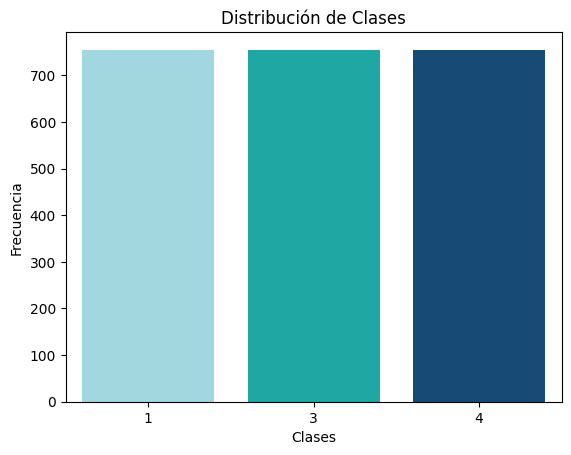

In [85]:
# 9. Distribución de etiquetas
print("Distribución de clases:")
dist_df = pd.DataFrame(
    {
        "cantidad": df_train_final["labels"].value_counts(),
        "porcentaje": round(df_train_final["labels"].value_counts() / len(df_train_final), 2),
    }
)
print(dist_df)
distribucion_clases(df_train_final)

In [86]:
X_train_new = df_train_final["textos"]
y_train_new = df_train_final["labels"]
X_val_aug = df_val["textos"]
y_val_aug = df_val["labels"]

In [87]:
tokenizer_aug = WordTokenizerTransformer()
X_train_tokenized_aug = tokenizer_aug.fit_transform(X_train_new)
X_val_tokenized_aug = tokenizer_aug.transform(X_val_aug)

Modelo con aumento:
              precision    recall  f1-score   support

           1       0.91      0.96      0.93       101
           3       0.96      0.95      0.96       195
           4       0.99      0.96      0.97       208

    accuracy                           0.96       504
   macro avg       0.95      0.96      0.95       504
weighted avg       0.96      0.96      0.96       504



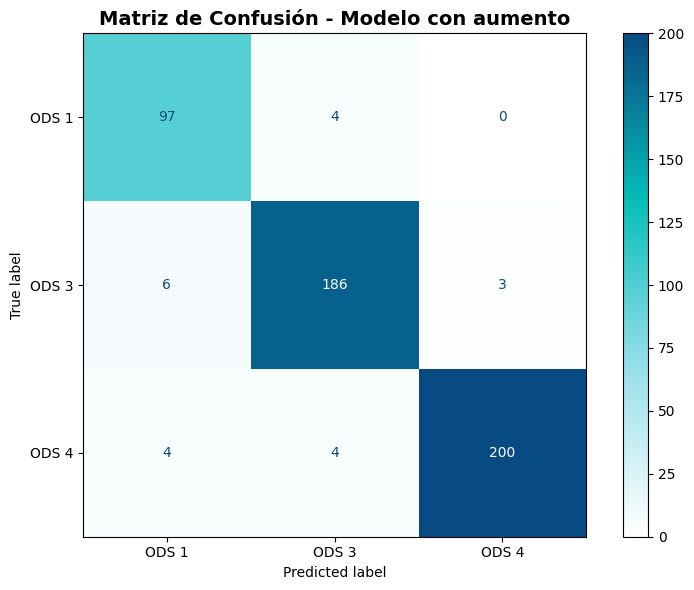

In [94]:
vectorizer_aug = CountVectorizer(ngram_range=(1,1))
X_train_vec_aug = vectorizer_aug.fit_transform(X_train_tokenized_aug)
X_val_vec_real = vectorizer_aug.transform(X_val_tokenized_aug)

model_aug = LogisticRegression(max_iter=1000, random_state=42)
model_aug.fit(X_train_vec_aug, y_train_new)

y_val_pred_real = model_aug.predict(X_val_vec_real)
print("Modelo con aumento:")
print(classification_report(y_val_aug, y_val_pred_real))
matriz_confusion(
    y_true=y_val_aug,
    y_pred=y_val_pred_real,
    etiquetas=["ODS 1", "ODS 3", "ODS 4"],
    titulo="Matriz de Confusión - Modelo con aumento"
)

# Comparación entre modelos 


In [98]:
X_test_comparacion = df_test["textos"]
y_test_comparacion = df_test["labels"]

## Modelo sin agregación 

              precision    recall  f1-score   support

           1       0.98      0.94      0.96        51
           3       0.99      0.98      0.98        97
           4       0.96      0.99      0.98       105

    accuracy                           0.98       253
   macro avg       0.98      0.97      0.97       253
weighted avg       0.98      0.98      0.98       253



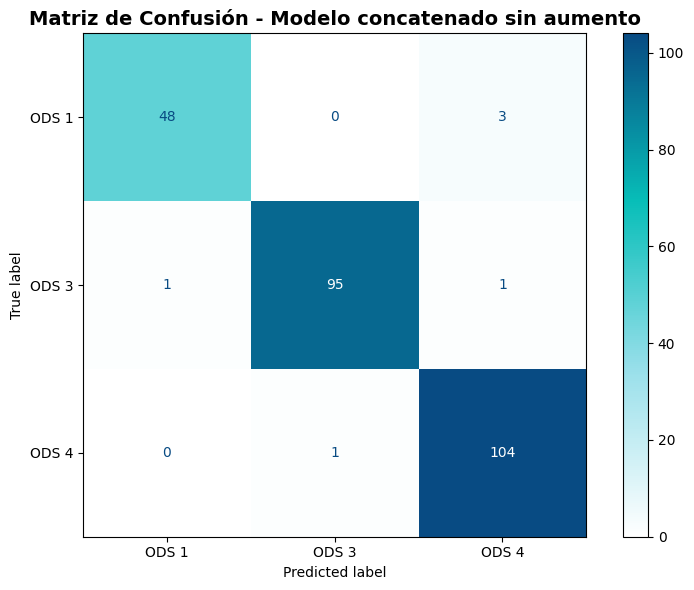

In [99]:
X_test_tokenized_no_aug = tokenizer_concat.transform(X_test_comparacion)
X_test_vec_no_aug = vectorizer_real.transform(X_test_tokenized_no_aug)
y_test_pred_no_aug = model_real.predict(X_test_vec_no_aug)
print(classification_report(y_test_comparacion,y_test_pred_no_aug))
matriz_confusion(
    y_true=y_test_comparacion,
    y_pred=y_test_pred_no_aug,
    etiquetas=["ODS 1", "ODS 3", "ODS 4"],
    titulo="Matriz de Confusión - Modelo concatenado sin aumento"
)

## Modelo con agregación 

              precision    recall  f1-score   support

           1       0.98      0.96      0.97        51
           3       0.96      0.98      0.97        97
           4       0.97      0.96      0.97       105

    accuracy                           0.97       253
   macro avg       0.97      0.97      0.97       253
weighted avg       0.97      0.97      0.97       253



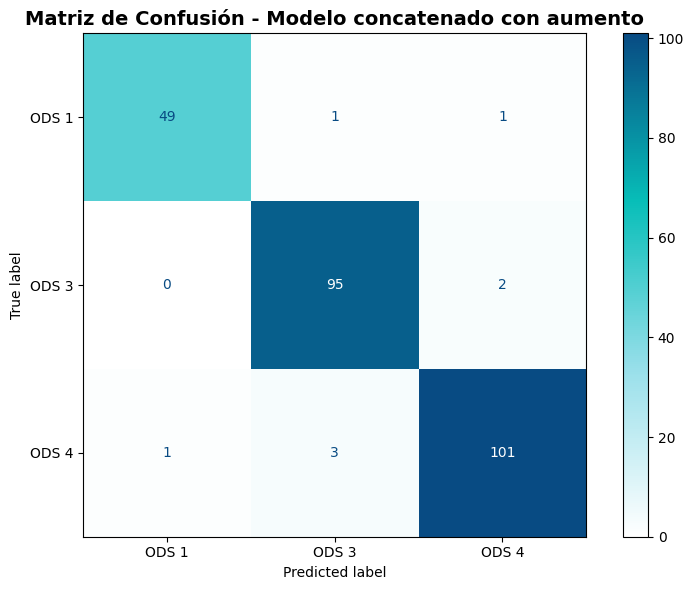

In [100]:
X_test_tokenized_aug = tokenizer_aug.transform(X_test_comparacion)
X_test_vec_aug = vectorizer_aug.transform(X_test_tokenized_aug)
y_test_pred_aug = model_aug.predict(X_test_vec_aug)
print(classification_report(y_test_comparacion,y_test_pred_aug))
matriz_confusion(
    y_true=y_test_comparacion,
    y_pred=y_test_pred_aug,
    etiquetas=["ODS 1", "ODS 3", "ODS 4"],
    titulo="Matriz de Confusión - Modelo concatenado con aumento"
)